In [1]:
!pip -q install yfinance

In [23]:
import pandas as pd
from collections import Counter
from keras.utils.vis_utils import plot_model
import requests
import bs4 as bs
import yfinance as yf
import datetime as dt
import numpy as np
from collections import deque
import random
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Nadam,Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [4]:
def preprocess_df(df):
    df = df.drop("future_date", 1)
    df = df.drop("vola", 1)
    df = df.drop('price',1)
    df = df.drop('Date',1)
    for col in df.columns:
        if col != "target":
            df[col] = df[col].pct_change()
            df=df.replace([np.inf, -np.inf], np.nan)

            df.dropna(inplace=True)
            
    df.dropna(inplace=True)

    sequential_data = []
    prev_days = deque(maxlen=SEQ_LEN)

    for i in df.values:
        prev_days.append([n for n in i[:-1]])
        if len(prev_days) == SEQ_LEN:
            sequential_data.append([np.array(prev_days), i[-1]])

    random.shuffle(sequential_data)

    X = []
    y = []

    for seq, target in sequential_data:
        X.append(seq)
        y.append(target)

    return np.array(X), np.array(y)
def date_init(hist,dates):
  close = list(hist['Close'])
  hist_date = list(hist.index)
  dates = [dt.date(int('20'+i.split('/')[-1]),int(i.split('/')[0]),int(i.split('/')[1])) for i in dates]
  hist_date = [str(i).split(' ')[0] for i in hist_date]
  hist_date = [dt.date(int(i.split('-')[0]),int(i.split('-')[1]),int(i.split('-')[2])) for i in hist_date]
  prices = {}
  trends = {}
  fixed=[]
  for i,j in zip(hist_date,close):
    prices[i]=j
  for date in dates:
    try:
      fixed.append(prices[date])
    except:
      fixed.append(np.nan)
            
  return fixed

def organ(df):
  dates = df['Date']
  trends = df['Trend']
  start = [int(i) for i in dates[0].split('-')]
  start = dt.date(start[0],start[1],start[2]) + dt.timedelta(days=-2)
  start = f'{start.year}-{start.month}-{start.day}'
  end = df['Date'][len(df['Date'])-1]
  hist = stock.history(start=start,end=end)
  hist_date = list(hist.index)
  dates = [dt.date(int(i.split('-')[0]),int(i.split('-')[1]),int(i.split('-')[2])) for i in dates]
  hist_date = [str(i).split(' ')[0] for i in hist_date]
  hist_date = [dt.date(int(i.split('-')[0]),int(i.split('-')[1]),int(i.split('-')[2])) + dt.timedelta(days=2) for i in hist_date]
  close = hist['Close']
  prices = {}
  values={}
  for i,j in zip(hist_date,close):
    prices[i] = j
  for date,trend in zip(dates,trends):
    try: values[date] = [prices[date],trend]
    except: values[date] = [np.nan,trend]
  return values
def clean(date):
  cut = date.split('/')
  day = int(cut[1])
  month = int(cut[0])
  year = int('20'+cut[-1])
  return dt.date(year,month,day)
def vola_ret(date):
  tomorrow = date+dt.timedelta(days=4)
  sp = yf.Ticker("^GSPC")
  hist = sp.history(start=date,end=tomorrow,interval='60m')[:7]
  prices = hist['Close']
  return prices.std()
def classify(vola):
  if vola>12:
    return 1
  return 0

In [5]:
vola_ret(dt.date(2020,4,25))

5.3727513568801974

In [ ]:
###SARS###
df_raw = pd.read_csv('sars_2003_complete_dataset_clean.csv')
indexes = [i for i in range(len(df_raw)) if df_raw['Country'][i] == 'United States'][28:]

df = pd.DataFrame()
df['Date'] = [df_raw['Date'][i] for i in indexes]
df['cases'] = [df_raw['Cumulative number of case(s)'][i] for i in indexes]
print(df)


FileNotFoundError: ignored

In [6]:
###CORONAVIRUS###
import json
countries = ['US']
datec = []
df = pd.DataFrame()
data=[]
SEQ_LEN=3
for country in countries:
  print(country)
  req = requests.get(f'https://api.thevirustracker.com/free-api?countryTimeline={country}')
  soup = bs.BeautifulSoup(req.text,'lxml')
  jsons = json.loads(soup.text)
  info = jsons['timelineitems'][0]
  cases=[]
  deaths=[]
  dates = [i for i in info]
  
  real_dates=[]
  for date in dates:
    try:
      cases.append(info[date]['total_cases'])
      deaths.append(info[date]['total_deaths'])
      real_dates.append(date)
    except:break
  datec.append(len(real_dates))
  data.append([real_dates,cases,deaths])
datec = min(datec)-2
for index,country in enumerate(data):
  date = country[0]
  date = date[len(date)-datec:]
  cases = country[1]
  cases = cases[len(cases)-datec:]
  deaths = country[2]
  deaths = deaths[len(deaths)-datec:]
  df[f'{countries[index]}_cases'] = cases
  df[f'{countries[index]}_deaths'] = deaths
df['Date'] = date
start = df['Date'][0].split('/')
start = dt.datetime(int('20'+start[-1]),int(start[0]),int(start[1]))
end = list(df['Date'])[-1].split('/')
end = dt.datetime(int('20'+end[-1]),int(end[0]),int(end[1]))+dt.timedelta(days=1)
stock = yf.Ticker('^GSPC')
hist = stock.history(start=start,end=end)
price = date_init(hist,list(df['Date']))
df['price']= price
df.fillna(method='ffill',inplace=True)
df['future_date'] = df['Date'].shift(-1)
df.dropna(inplace=True)
df['future_date'] = list(map(clean,df['future_date']))
df['vola'] = list(map(vola_ret,df['future_date']))
df['target'] = list(map(classify,df['vola']))
X,y = preprocess_df(df)
train_x, test_x, train_y, test_y = train_test_split(X,y, test_size=0.2)
print(Counter(y))

US
Counter({1.0: 56, 0.0: 55})


In [45]:
model = Sequential()

model.add(LSTM(12,input_shape=(3,2),return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(8))
model.add(Dropout(0.3))
model.add(Dense(2,activation='softmax'))
model.compile(optimizer=Adam(lr=1e-30),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 3, 12)             720       
_________________________________________________________________
dropout_28 (Dropout)         (None, 3, 12)             0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 8)                 672       
_________________________________________________________________
dropout_29 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 18        
Total params: 1,410
Trainable params: 1,410
Non-trainable params: 0
_________________________________________________________________


In [60]:
hist=model.fit(train_x,train_y,batch_size=1,epochs=15)

Epoch 1/15
88/88 [==============================] - 0s 3ms/step - loss: 0.6922 - accuracy: 0.5341
Epoch 2/15
88/88 [==============================] - 0s 3ms/step - loss: 0.6924 - accuracy: 0.4205
Epoch 3/15
88/88 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.4545
Epoch 4/15
88/88 [==============================] - 0s 3ms/step - loss: 0.6920 - accuracy: 0.4886
Epoch 5/15
88/88 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.4659
Epoch 6/15
88/88 [==============================] - 0s 3ms/step - loss: 0.6928 - accuracy: 0.4659
Epoch 7/15
88/88 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.4432
Epoch 8/15
88/88 [==============================] - 0s 3ms/step - loss: 0.6925 - accuracy: 0.4886
Epoch 9/15
88/88 [==============================] - 0s 3ms/step - loss: 0.6924 - accuracy: 0.4432
Epoch 10/15
88/88 [==============================] - 0s 3ms/step - loss: 0.6944 - accuracy: 0.4773
Epoch 11/15
88/88 [

In [64]:
#model = load_model('corona_model.h5')
model.evaluate(test_x+train_x,test_y+train_y)

one_good = 0
one_bad = 0
good = 0
bad=0
for i,j in zip(test_x+train_x,test_y+train_y):
  true = j
  predict = np.argmax(model.predict(np.array([i])))
  if true == 0:
    if predict == 0:
      good+=1
    else:
      bad +=1
  else:
    if predict == 1:
      one_good+=1
    else:
      one_bad+=1
print(good,bad)
print(one_good,one_bad)

ValueError: ignored

In [ ]:
model.save('corona_model.h5')

In [ ]:
model.save('corona_model.h5')

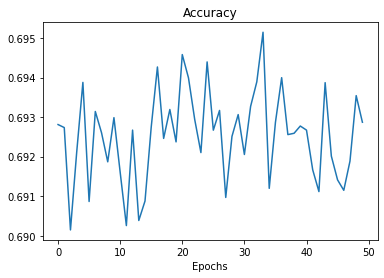

In [ ]:
plt.plot(hist.history['loss'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.show()